In [28]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src/')

In [82]:
from data.create_dataset import *
from visualization.visualize import *

Loading data from file

In [131]:
N = 100
z = load_data('../data/raw/SRTM_data_Norway_1.tif',N,N)
print(z.shape)

(100, 100)


Creating meshgrid with x and y in the range (0,1).

In [132]:
x,y = create_normalized_meshgrid(N,N)
x.shape

(100, 100)

Plotting colormap of terrain

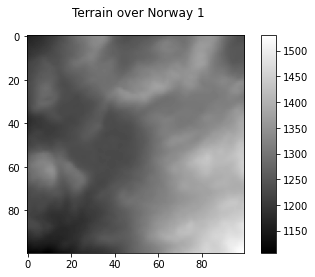

In [133]:
fig = plot_colormap(z,N,N,'gray')

Creating design matrix

In [134]:
X = create_poly_design_matrix(x,y,2)
X.shape

(10000, 6)

Plotting the surface, both from the meshgrid and directly from the design matrix

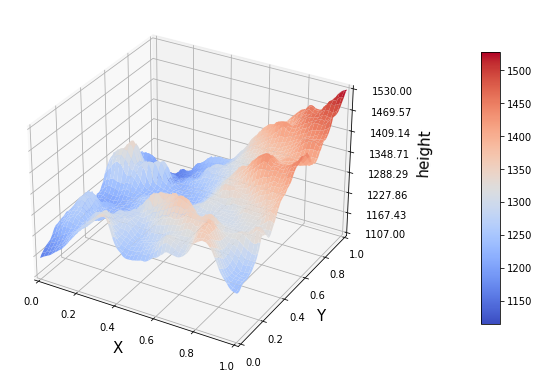

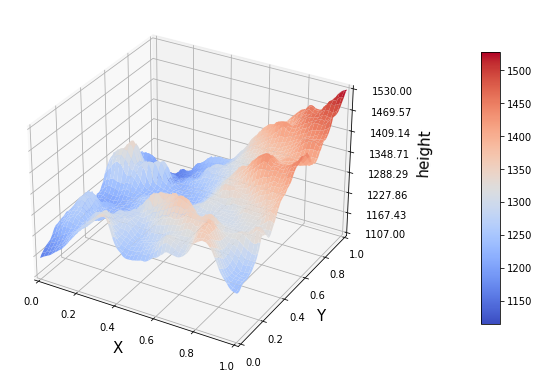

In [142]:
surf = plot_surf(x,y,z,N,N)
surf = plot_surf_from_X(X,z,N,N)

Scale the data -> show scaled data -> show another scaled data.
Before scaling the data, we must ensure that the target data matrix z is flattened. If not, the scaler will assume each column is a feature and thereby scale across each x-value.

In [136]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
z_ssScaler = StandardScaler()
z_mmScaler = MinMaxScaler()

z's shape is (N,N) but we need it to be (N^2,1). When plotting we need to revert to original shape. So must ensure that reshaping doesn't change the data.
We can use reshape(-1,1) directly instead of ravelling first.

In [137]:
z1 = z.reshape(-1,1)
z2 = z.ravel().reshape(-1,1)
z1-z2

Array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int16)

In [138]:
z1_ = z1.reshape(N,N)
z2_ = z2.reshape(N,N)
z1_-z2_

Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

Shape (-1,1) can be plotted with current plot_surface function

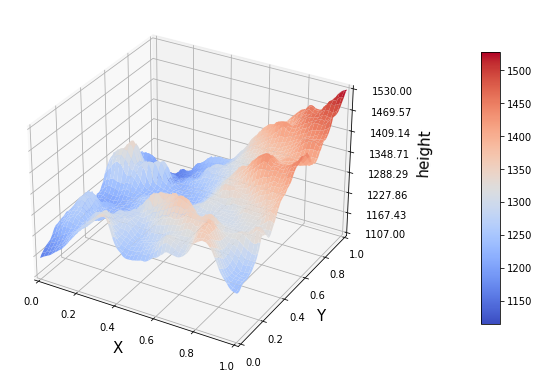

In [141]:
z = z.reshape(-1,1)
z.shape
surf2 = plot_surf(x,y,z,N,N)

Are there any difference in scaling with minmax or standard scaler? Is z invariant to both? They obviously produce different results, but is the relative difference between the data still the same? How to check that? I guess if we min-max the standardized data it should be equal to the originally min-maxed data or else relative difference has been changed, I think?

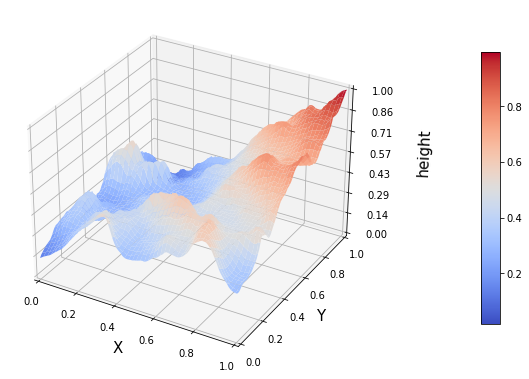

In [143]:
z_scaled_mm = z_mmScaler.fit_transform(z)
surf = plot_surf(x,y,z_scaled_mm,N,N)

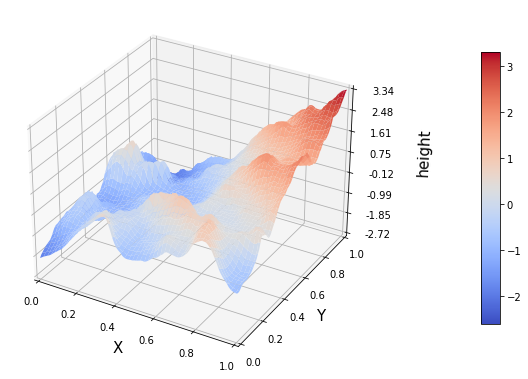

In [145]:
z_scaled_ss = z_ssScaler.fit_transform(z)
surf = plot_surf(x,y,z_scaled_ss,N,N)

And they are practically the same. The curvatures also look very much alike. But it actually makes sense mathematically too. Because, in both cases the whole column(which is all the data) is scaled by the same values. MinMax is like Standardization but with mean = min(z) and std = (max(z)-min(z))

In [148]:
z_scaled_ss_mm = z_mmScaler.fit_transform(z_scaled_ss)
z_scaled_mm - z_scaled_ss_mm

array([[-5.55111512e-17],
       [-5.55111512e-17],
       [-5.55111512e-17],
       ...,
       [-2.22044605e-16],
       [-3.33066907e-16],
       [ 0.00000000e+00]])

But is there a reason to scale target data? A more wobbly surface needs higher coefficients for the model to reach the data points. I assume the relative difference between coefficients would be the same if the curvature is exactly the same but on another scale. But what about Ridge and Lasso? I then think that the optimal lambda is somehow scaled such that one could get the exact same relative difference between the coefficients. As such, the only arguments i find for scaling target data is to ensure consistent scale on the MSE as well.

What about scaling design matrix when x,y in [0,1]?

In [149]:
X_ssScaler = StandardScaler()
X_mmScaler = MinMaxScaler()
X_ss = X_ssScaler.fit_transform(X)
X_mm = X_mmScaler.fit_transform(X)

The plots of these obviously becomes the same as above, since we're only using the x and y columns of X, which are scaled similarily as z.

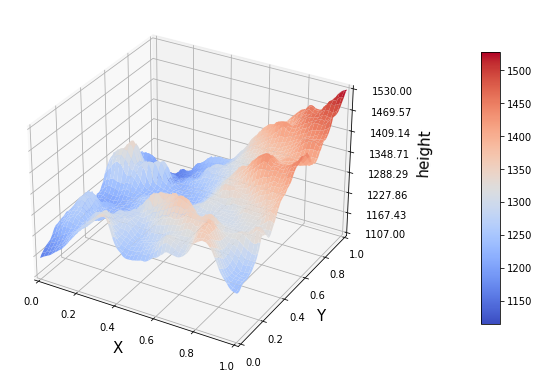

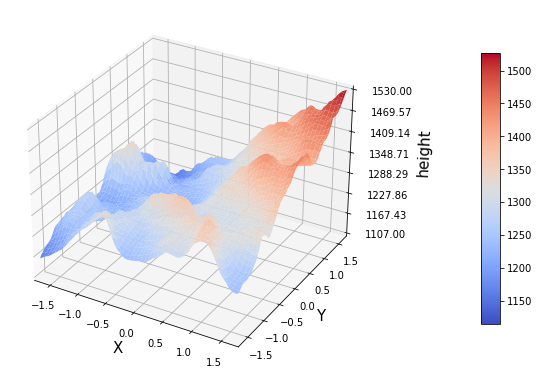

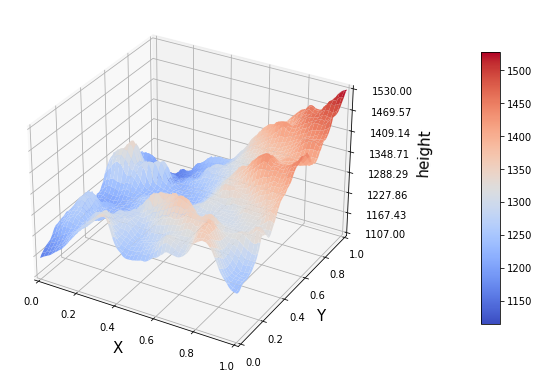

In [154]:
surf3 = plot_surf_from_X(X,z,N,N)
surf4 = plot_surf_from_X(X_ss,z,N,N)
surf5 = plot_surf_from_X(X_mm,z,N,N)

So only argument here is that regularization punishes high bias features. So, all features should have mean 0, with Lasso and Ridge. Always. Sklearn does this actually. Furthermore, I assume the same holds wrt